# Classification analysis 

Although the assignment is not to classify sushi and sandwich from one another, it is a key part of the process that I ended up using. This notebook is an analysis of the performance of the classifiers since, if they aren't performant, finding 'sanushi' images will be more challenging. 

In [1]:
from os.path import join, exists

import numpy as np 
import pandas as pd 

from torchvision import datasets

from tabulate import tabulate

from sklearn.externals import joblib

import json

from PIL import Image

import matplotlib.pyplot as pl 
import seaborn as sns 

from utils import figure_loader

sns.set_style("darkgrid")

%matplotlib inline

## Define some convenience functions

In [2]:
def load_result_file(feat_name, model_name, split="test", metric="accuracy"): 
    results = json.load(open(join(
        "results", feat_name, f"{model_name}-results.json"
    ), "r"))

    return [res[split][metric] for res in results]

def load_results(feat_names, model_names, metric="accuracy", split="test", return_raw=False): 
    results = []
    for feat_name in feat_names: 
        for model_name in model_names: 
            try:
                res = load_result_file(
                    feat_name=feat_name, 
                    model_name=model_name, 
                    metric=metric, 
                    split=split
                )
                res = {f'fold_{fi}': ri for fi, ri in enumerate(res)} 
                res['feat'] = feat_name
                res['model'] = model_name
                results.append(res)
            except FileNotFoundError: 
                pass
            
    if return_raw: 
        return results
    df = pd.DataFrame(results)
    df.set_index('feat', inplace=True)
    return df

## Define some parameters that are useful for the analysis

In [3]:
labels = [
    'sandwich', 
    'sushi',
]

feat_names = [
    "alexnet", 
    "vgg11", 
    "inception", 
    "mobilenet", 
    "ensemble",
]

model_names = [
    "sgd", 
    "pcasgd",
    "gmm",
]

## Load and print the test set results over the feature representations

A conclusion of this is that the ensemble model is most accurate, beating the alexnet features by approx 6% on the test set, and gaining approximately 1% accuracy over the second-best model (mobilenet). These results (see below) seem to be consistent across folds, and so in the selection of sanushi images in the other notebook, I will exclusively use the ensemble results. 

In [4]:
results_df = load_results(
    feat_names=feat_names, 
    model_names=model_names,
)

fold_names = [col for col in results_df.columns if 'fold' in col]

results_df.reset_index().groupby(['model', 'feat']).mean()

fold_0    fold_1   fold_2   fold_3   fold_4
model  feat                                                    
gmm    alexnet    0.813580  0.822222  0.78375  0.82125  0.75875
       ensemble   0.877778  0.920988  0.88750  0.89750  0.87375
       inception  0.817284  0.897531  0.88750  0.86000  0.83250
       mobilenet  0.864198  0.895062  0.87875  0.90375  0.84375
       vgg11      0.822222  0.838272  0.86250  0.83750  0.81375
pcasgd alexnet    0.869136  0.846914  0.86750  0.87750  0.82625
       ensemble   0.909877  0.927160  0.94500  0.92375  0.87625
       inception  0.865432  0.909877  0.90750  0.87125  0.85250
       mobilenet  0.881481  0.907407  0.92625  0.91625  0.87000
       vgg11      0.871605  0.909877  0.89750  0.88375  0.84000
sgd    alexnet    0.854321  0.838272  0.86250  0.87500  0.83500
       ensemble   0.902469  0.923457  0.94500  0.92625  0.87375
       inception  0.876543  0.904938  0.89500  0.87250  0.83625
       mobilenet  0.870370  0.913580  0.92875  0.92000  0.87500
       vgg11      0.872840  0.904938  0.90875  0.87375  0.85500

In [5]:
pd.DataFrame(results_df.reset_index().groupby(['model', 'feat']).mean().mean(axis=1)).unstack(-1).T

model             gmm    pcasgd       sgd
  feat                                   
0 alexnet    0.799910  0.857460  0.853019
  ensemble   0.891503  0.916407  0.914185
  inception  0.858963  0.881312  0.877046
  mobilenet  0.877102  0.900278  0.901540
  vgg11      0.834849  0.880546  0.883056

## Plot the results across folds

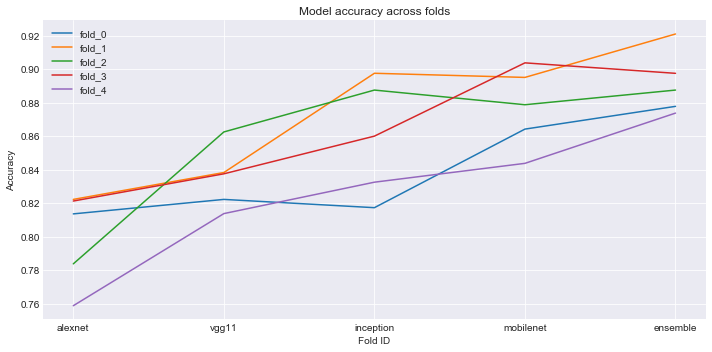

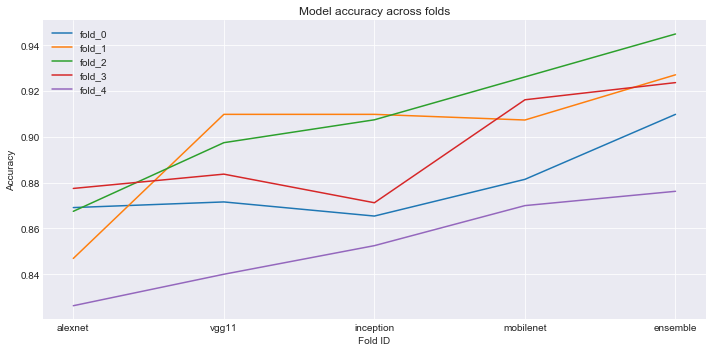

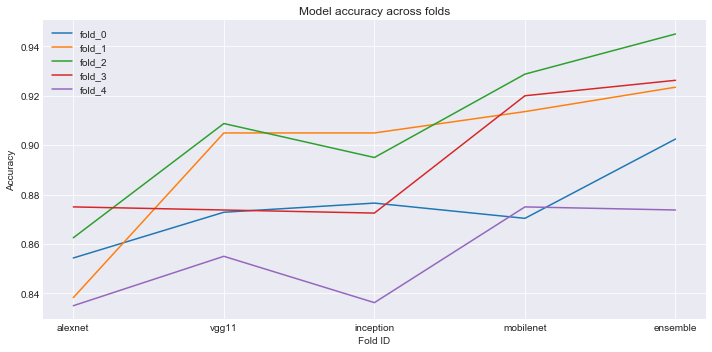

In [6]:
for model_name, group in results_df.groupby('model'):
    fig, ax = pl.subplots(1, 1, figsize=(10, 5))
    group.plot(ax=ax)
    pl.xticks(np.arange(len(group)), group.index)
    pl.xlabel("Fold ID")
    pl.ylabel("Accuracy")
    pl.title("Model accuracy across folds")
    pl.tight_layout()
    pl.savefig(join("figures", f"acc-fold-{model_name}.pdf"))

## Plot results across models

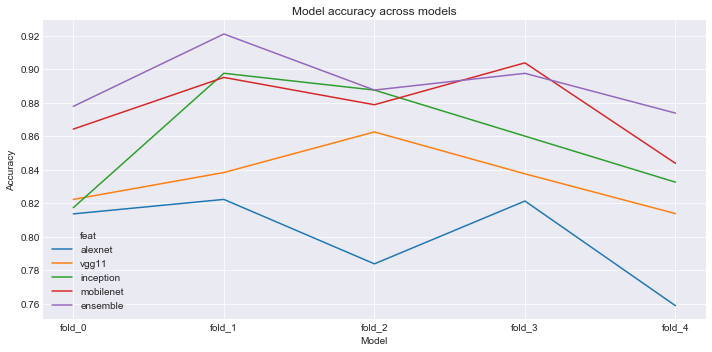

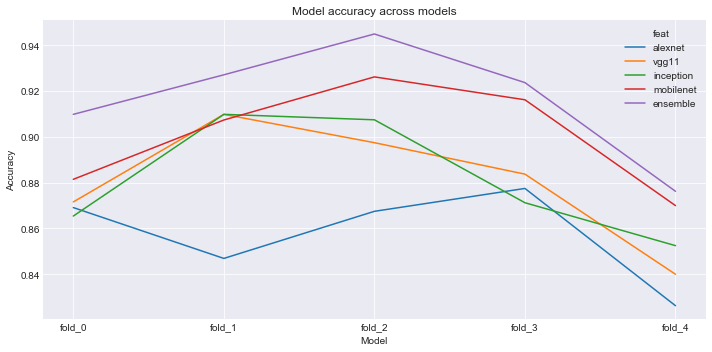

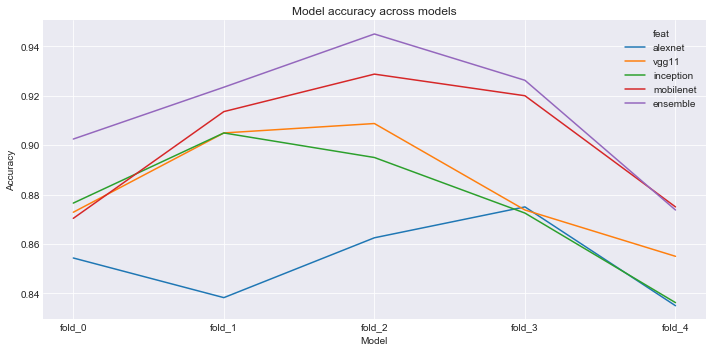

In [7]:
for model_name, group in results_df.groupby("model"):
    group = group[fold_names]
    fig, ax = pl.subplots(1, 1, figsize=(10, 5))
    group.T.plot(ax=ax) 
    pl.xticks(np.arange(len(group.columns)), group.columns)
    pl.xlabel("Model")
    pl.ylabel("Accuracy")
    pl.title("Model accuracy across models")
    pl.tight_layout()
    pl.savefig(join("figures", f"acc-models-{model_name}.pdf"))

## Print the confusion matrices averaged across folds

Of note: 
    
- actual sushi tend to be misclassified more than actual sandwich
    - This is consistent across all representations 
    - Even in the ensemble model (the best performing one) has 2x sushi prediction errors 
- VGG and Inception representations tend to have the best balance between the errors

In [8]:
for model_name, group in results_df.groupby("model"):
    cm_df = load_results(
        feat_names=feat_names, 
        model_names=[model_name],
        metric="confusion_matrix", 
        split="test", return_raw=False
    )
    
    print(f"Confusion matrices for {model_name}")
    for feat_name, cm_list in cm_df.iterrows(): 
        cms = np.asarray([rr for rr in cm_list[fold_names].values])
        cm = np.sum(cms, 0)
        cm = np.concatenate((cm, cm.sum(1)[:, None]), 1)
        cm = np.concatenate((cm, cm.sum(0)[None, :]), 0)
        cm = pd.DataFrame(
            cm, columns=("Predicted sandwich", "Predicted sushi", "Sum")
        )
        cm.index = ("Actual sandwich", "Actual sushi", "Sum")

        print(f"Confusion matrix for {feat_name} {model_name}")
        print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))
        print()
    print('\n\n')

Confusion matrices for gmm
Confusion matrix for alexnet gmm
╒═════════════════╤══════════════════════╤═══════════════════╤═══════╕
│                 │   Predicted sandwich │   Predicted sushi │   Sum │
╞═════════════════╪══════════════════════╪═══════════════════╪═══════╡
│ Actual sandwich │                 1647 │               363 │  2010 │
├─────────────────┼──────────────────────┼───────────────────┼───────┤
│ Actual sushi    │                  441 │              1569 │  2010 │
├─────────────────┼──────────────────────┼───────────────────┼───────┤
│ Sum             │                 2088 │              1932 │  4020 │
╘═════════════════╧══════════════════════╧═══════════════════╧═══════╛

Confusion matrix for vgg11 gmm
╒═════════════════╤══════════════════════╤═══════════════════╤═══════╕
│                 │   Predicted sandwich │   Predicted sushi │   Sum │
╞═════════════════╪══════════════════════╪═══════════════════╪═══════╡
│ Actual sandwich │                 1693 │              

## Plot some cross validation results 

Note: 

- The results seem to be very stable across several iterations
- Although I performed a very wide search of parameters (ranging from 10^-10 to 10^5) this figure shows that the key range is between 10^-2 and 10^2. 

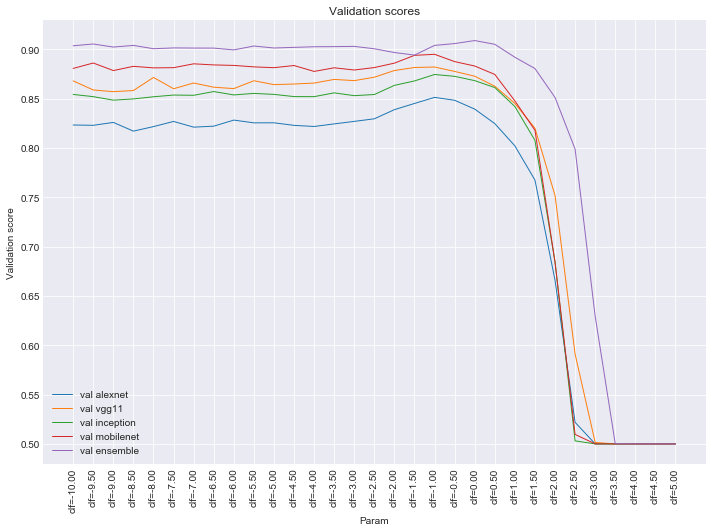

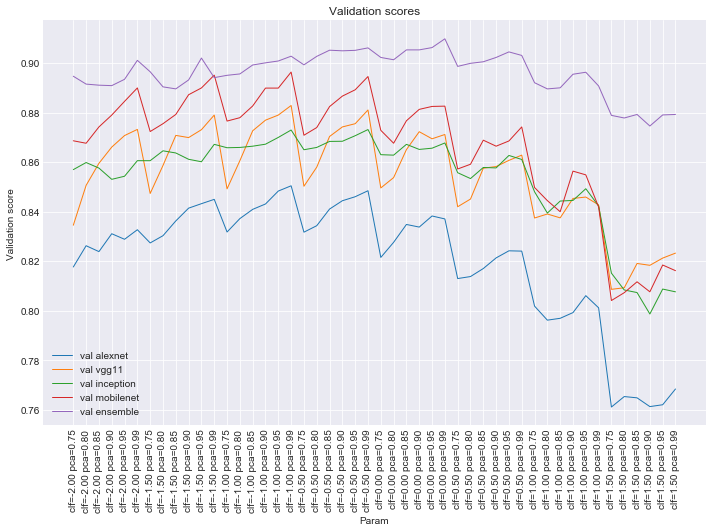

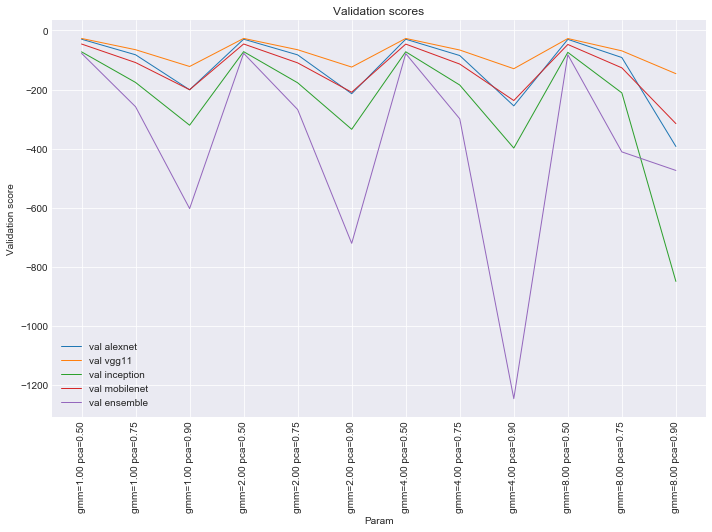

In [9]:
colours = sns.color_palette()
for model_name in model_names:
    fig, ax = pl.subplots(1, 1, figsize=(10, 7.5))
    for feat_name, ci in zip(feat_names, colours):
        fname = join('results', feat_name, f'{model_name}-results.json')
        if not exists(fname): 
            continue 
        results = json.load(open(fname))
        yy = np.asarray([res['xval']['mean_test_score'] for res in results])
        pl.plot(yy.mean(axis=0), c=ci, lw=1.0, ls='-', label=f'val {feat_name}')
    labels = []
    for param in results[0]['xval']['params']:
        label = []
        for kk, vv in param.items():
            if 'alpha' in kk: 
                vv = np.log10(vv)
            label.append(
                f"{kk.split('__')[0]}={vv:.2f}"
            )
        labels.append(' '.join(label))
    pl.xticks(np.arange(len(labels)), labels, rotation=90)
    pl.legend(loc=3)
    pl.xlabel("Param")
    pl.ylabel("Validation score")
    pl.title("Validation scores")
    pl.tight_layout()
    pl.savefig(join("figures", f"xval-acc-{model_name}.pdf"))